## Magnetic Bottle
2D simulations of Single Particle Drifts
***

#### About the simulation

We will be using the 2D version of **ZPIC**. With this particle in cell code we are required to initialize a full plasma instead of a single particle. However, we may still track single particles and eliminate collective effects by decreasing the plasma density.


#### About the phenomenon

The magnetic bottle is a confinement machine that works based on the motion of single particles in magnetic fileds with parallel gradients.

The configuration is based on the following picture:

<img src="config.png"  style="width: 500px; float: left;" />





Taken from Freidberg, *Plasma Physics and Fusion Energy*.

Two coils with current flowing in the same direction create a magnetic field<br>
with a maximum just under each coil and a local minimum midway between.

In this device, the particle may undergo an harmonic motion due to the restoring<br> force $F_\parallel=-\mu\nabla_\parallel B$, where $\mu=\frac{mv_\perp^2}{2B}$ is an adiabatic invariant, *i.e.*, it remains constant<br> for a given particle.

#### The simulation

We initialize the simulation with an electron species localized between $4.4<x_1<4.6$ and $0.24<x_2<0.26$.

We give it a uniform velocity distribution in the $x_1$ direction, but  a thermal velocity distribution in the $x_2$ direction.
In this way, some particles will have a pitch angle small enough to escape the magnetic bottle while others will remain trapped.


In [748]:
# get ZPIC 2D
import em2d
import numpy as np

# Simulation time
tmax = 250
# Number of cells
nx  = [480+128,32]
# Simulation box size
box = [18,0.5]

#Time step
def courant(dx,dy):
    return 1/np.sqrt(1/dx**2+1/dy**2)
dt = 0.999*courant(box[0]/nx[0],box[1]/nx[1])

# Particles per cell
ppc = [8,32]

def custom_nx(x):
    return 1.0 if (x>4.4 and x<4.6)  else 0.0

def custom_ny(x):
    return 1.0 if (x>0.24 and x<0.26) else 0.0

dens = em2d.Density( type = "custom", custom_x = custom_nx,custom_y = custom_ny  )
# Set up a super low density
dens.n=1e-6

ufl=0.05
#create the species
electrons = em2d.Species( "electrons", -1, ppc,
                           density = dens,ufl=[ufl,0,0],uth=[0,2*ufl,0],n_sort=0)

# Initialize simulation
sim = em2d.Simulation( nx, box, dt, species = (electrons) )

##### External fields

We will be using the python package ```loopfield``` to obtain the magnetic field coming from two current loops plasced at the edges of the simulation box.

The current loops are placed in such a way that the plasma particles begin their motion in the middle of the bottle

In [749]:
import loopfield as lf
# create empty field with specified units
field = lf.Field(length_units = lf.cm,
                 current_units = lf.A,
                 field_units = lf.uT)

position = [9., 0.25, 0.]
normal = [1., 0., 0.]
radius = 5.
current = 0.4
c = lf.Loop(position, normal, radius, current)

position = [0., 0.25, 0.]
d = lf.Loop(position, normal, radius, current)

# add loop to field
field.addLoop(c);
field.addLoop(d);

We pre-calculate the external field in order to save a bit o computing time

In [750]:
#Pre-caclculate the external fields 
gc=[[1,2],[1,2]]
external_fld=[]
for i in range(nx[0]+gc[0][0]+gc[0][1]):
    ix=i-1
    external_fld_col=[]
    for j in range(nx[1]+gc[1][0]+gc[1][1]):
        iy=j-1
        x = ix*sim.dx[0]       
        y = (iy+0.5)*sim.dx[1]
        bx=field.evaluate([x,y,0])[0]

        x = (ix+0.5)*sim.dx[0]
        y = iy*sim.dx[1]      
        by,bz=field.evaluate([x,y,0])[1:]
        external_fld_col.append([bx,by,bz])        
    external_fld.append(external_fld_col)
print("done calculating ext")

def ext_B(ix,dx,iy,dy):
    i = ix+1
    j=  iy+1
    return external_fld[i][j]

ext = em2d.ExternalField(B_type = 'custom', B_custom = ext_B,E_type = 'none')
sim.emf.set_ext_fld( ext )

done calculating ext


Here you can check the longitudinal profile of the magnetic field

Text(0, 0.5, '$B_1$')

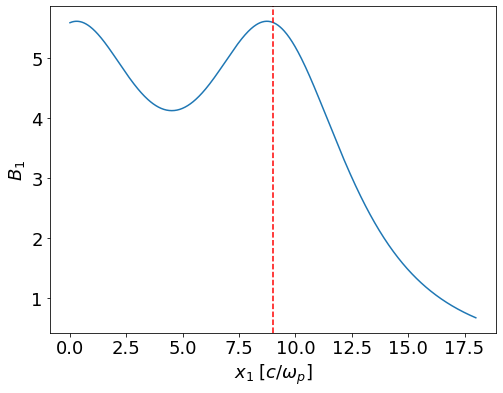

In [751]:
fig=plt.figure(figsize=(8, 6))
x=np.linspace(0,box[0],nx[0]+gc[0][0]+gc[0][1])
plt.plot(x,np.array(external_fld)[:,16,0],)
plt.xlabel("$x_1\;[c/\omega_p]$")
plt.axvline(9,c="r",ls="--")
plt.ylabel("$B_1$")

Now running the simulation

In [752]:
#arays to store the particles trajectories
ele_part_rep =[]

while sim.t < 230:
    print('n = {:d}, t = {:g}'.format(sim.n,sim.t), end = '\r')
    #store the electron trajectories
    if sim.n%10 ==0 :
        ele_part_rep.append(electrons.particles[:].copy())

    sim.iter()

### Checking the results

#### Plasma position.

As the simulation progresses, some plasma particles are able to leave the magnetic bottle and others bounce back.

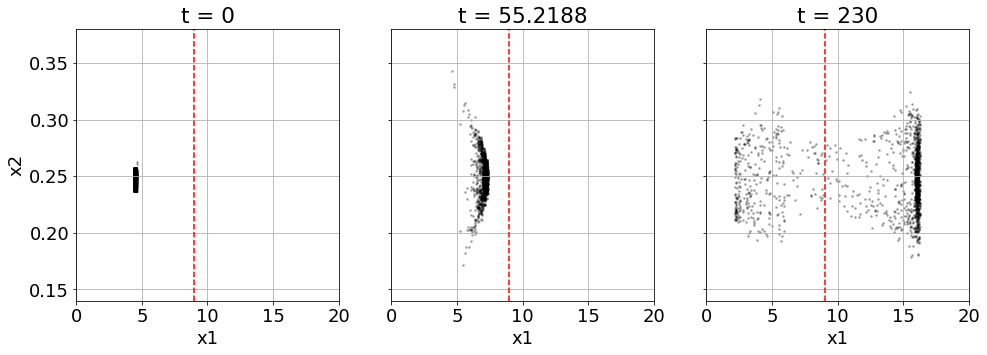

In [755]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

x = lambda s : (s['ix'] + s['x']) * sim.dx[0] 
y = lambda s : (s['iy'] + s['y']) * sim.dx[1]

xscat_0=[x(ai) for ai in ele_part_rep[0]]
yscat_0=[y(ai) for ai in ele_part_rep[0]]
axes[0].scatter(xscat_0,yscat_0,c="k",alpha=0.4,lw=0.1,s=5)

xscat_1=[x(ai) for ai in ele_part_rep[400]]
yscat_1=[y(ai) for ai in ele_part_rep[400]]
axes[1].scatter(xscat_1,yscat_1,c="k",alpha=0.4,lw=0.1,s=5)

xscat_2=[x(ai) for ai in ele_part_rep[-1]]
yscat_2=[y(ai) for ai in ele_part_rep[-1]]
axes[2].scatter(xscat_2,yscat_2,c="k",alpha=0.4,lw=0.1,s=5)
    
axes[0].set_title("t = {:g}".format(dt*0))
axes[1].set_yticklabels([])
axes[1].set_title("t = {:g}".format(dt*4000))
axes[2].set_yticklabels([])
axes[2].set_title("t = {:g}".format(dt*sim.n))


for ax in axes:
    ax.set_xlabel("x1")
    ax.set_xlim(0,20)
    ax.set_ylim(0.14,0.38)
    ax.axvline(9,ls="--",c="r")

    ax.grid()
    
axes[0].set_ylabel("x2")
plt.show()

Here you can find the same information ralayed in a movie.

In [756]:
import matplotlib.pyplot as plt
from matplotlib import animation
from IPython.display import display
import ipywidgets

# Create progress bar
label = ipywidgets.HTML()
display(label)

# Create plot
fig, ax = plt.subplots()
fig.set_size_inches( (8,6.0) )

# Simple function to convert particle positions
x = lambda s : (s['ix'] + s['x']) * sim.dx[0] 
y = lambda s : (s['iy'] + s['y']) * sim.dx[1]


(p1,) = ax.plot([], [],  '.', ms = 5,c="k")
ax.grid(True)

ax.set_xlim(0,22)
ax.set_ylim(0.1,0.4)
ax.axvline(9,ls="--",c="r")
plt.close(fig)
def animate(i):
    label.value = "Generating frame {:d}/{:d} ...".format(i+1,sim.n//10)

    p1.set_xdata([x(ai) for ai in ele_part_rep[i]])
    p1.set_ydata([y(ai) for ai in ele_part_rep[i]])
    ax.set_title(r"Simulation time {:.1f}".format(dt*i*10)+" [$\omega_p^{-1}$]")

    return (p1,)

# Create the movie
anim = animation.FuncAnimation( fig, animate, frames = sim.n//10, repeat = False, blit = True, interval = 1000.0/128 )
movie = ipywidgets.HTML(anim.to_html5_video())

# Show the completed movie
label.value = "Done!"
display(movie)

HTML(value='')

HTML(value='<video width="576" height="432" controls autoplay>\n  <source type="video/mp4" src="data:video/mp4…

#### Single particle behaviour

The trajectory of a single paticle can properly illustrate the phenomenon.

It starts in the middle of the bottle, and as it gets to regions of higher $B$ the perpendicular velocity increases and  the longitudinal velocity goes to zero, due to the conservation of magnetic momentum. This effect is clearly visible on the u1-x1 phasespace trajectory.
When it reaches 0, the particle bouces back until it reaches the other end of the bottle.

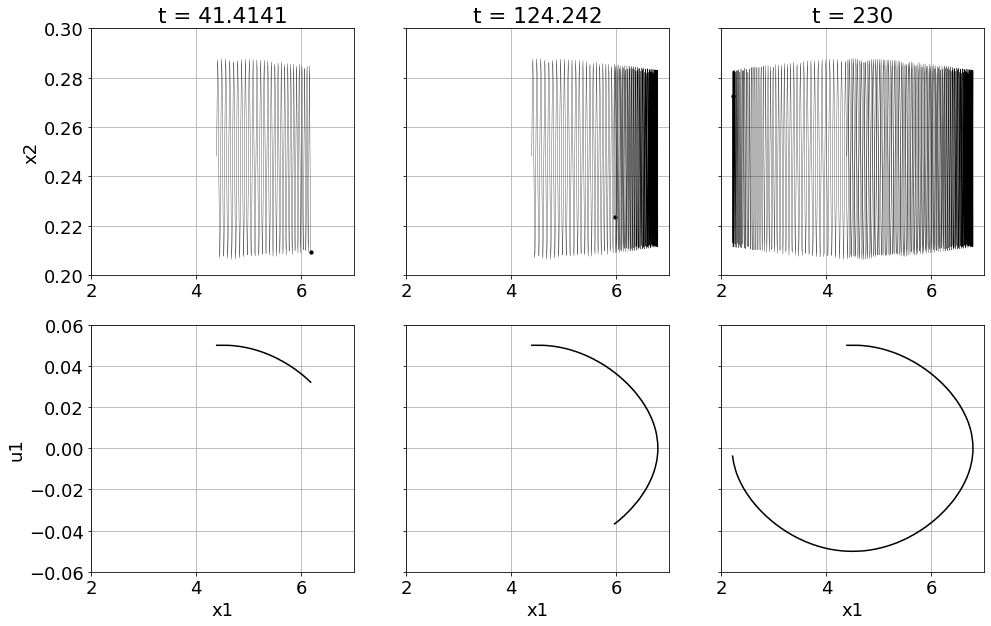

In [807]:
a=np.transpose(ele_part_rep)


import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 10))

e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[12]]
e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in a[12]]

axes[0,0].plot(e_posx_t[:300],e_posy_t[:300],c="k",lw=0.3)
axes[0,0].scatter(e_posx_t[300-1],e_posy_t[300-1],c="k",lw=0.3,s=15)
axes[0,1].plot(e_posx_t[:900],e_posy_t[:900],c="k",lw=0.3)
axes[0,1].scatter(e_posx_t[900-1],e_posy_t[900-1],c="k",lw=0.3,s=15)
axes[0,0].set_ylabel("x2")

axes[0,2].plot(e_posx_t[:-1],e_posy_t[:-1],c="k",lw=0.3)
axes[0,2].scatter(e_posx_t[-2],e_posy_t[-2],c="k",lw=0.3,s=15)

axes[0,0].set_title("t = {:g}".format(dt*3000))
axes[0,1].set_yticklabels([])
axes[0,1].set_title("t = {:g}".format(dt*9000))
axes[0,2].set_yticklabels([])
axes[0,2].set_title("t = {:g}".format(dt*sim.n))


e_ux_t=[i["ux"] for i in a[12]]
e_uy_t=[i["uz"] for i in a[12]]

axes[1,0].plot(e_posx_t[:300],e_ux_t[:300],c="k")
axes[1,1].plot(e_posx_t[:900],e_ux_t[:900],c="k")
axes[1,2].plot(e_posx_t[:-1],e_ux_t[:-1],c="k")
axes[1,0].set_ylabel("u1")

axes[1,1].set_yticklabels([])
axes[1,2].set_yticklabels([])

for ax in axes:
    for ax_ in ax:
        ax_.set_ylim(0.2,0.3)
        ax_.set_xlim(2,7)
        ax_.axvline(9,ls="--",c="r")
        ax_.grid()

for ax in axes[1,:]:
    ax.set_xlabel("x1")
    ax.set_ylim(-0.06,0.06)
    
plt.show()

#### Full picture

Looking at the trajecotries from all the particles in the bottle, we see that some particles bounce back before
the end of the bottle (in red, dashed), while others are able to go past the current loop without being reflected.

These particles were initialized with a low enough perpendicular velocity, such that the increase of the magnetic field felt by them is not enough to make their longitunidal velocity go to zero.

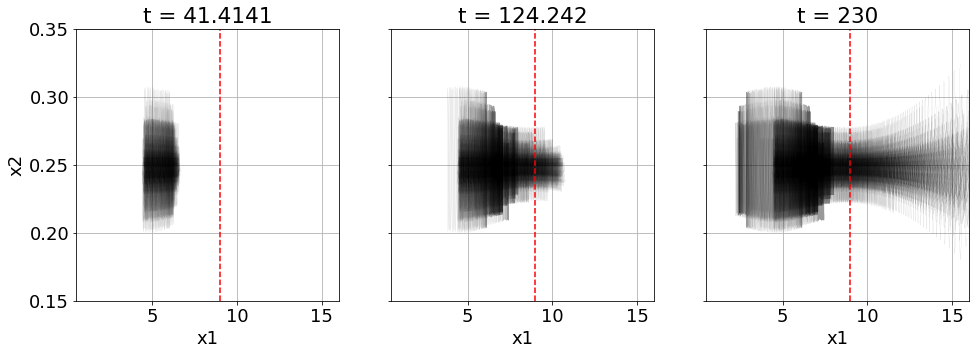

In [782]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 5))

tstep=-1

for j in range(len(electrons.particles))[::32]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[j][:tstep]]
    e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in a[j][:tstep]]
    axes[0].plot(e_posx_t[:300],e_posy_t[:300],c="k",alpha=0.4,lw=0.1)
    axes[1].plot(e_posx_t[:900],e_posy_t[:900],c="k",alpha=0.4,lw=0.1)
    axes[2].plot(e_posx_t,e_posy_t,c="k",alpha=0.4,lw=0.1)

    
axes[0].set_title("t = {:g}".format(dt*3000))

axes[1].set_yticklabels([])
axes[1].set_title("t = {:g}".format(dt*9000))

axes[2].set_yticklabels([])
axes[2].set_title("t = {:g}".format(dt*sim.n))


for ax in axes:
    ax.set_xlabel("x1")
    ax.set_xlim(0.5,16)
    ax.set_ylim(0.15,0.35)
    ax.axvline(9,ls="--",c="r")
    ax.grid()
    
axes[0].set_ylabel("x2")
#fig.suptitle("u1-x1 phasespace")
plt.show()

Here we plot these two groups of particles separately, togheter with the u1-x1 phasespace trajectories, where you can see that the trapped particles' long. velocity (in black) periodically goes from positive to negative values, whereas the free particles long velocity (in red) never goes below 0.

In [759]:
bound_idx=[]
unbound_idx=[]
for j in range(len(electrons.particles))[::]:
    if (a[j][-1]['ix']+a[j][-1]['x'])*box[0]/nx[0]>9 or min(a[j]["ux"])>0:
        unbound_idx.append(j)
    else:
        bound_idx.append(j)

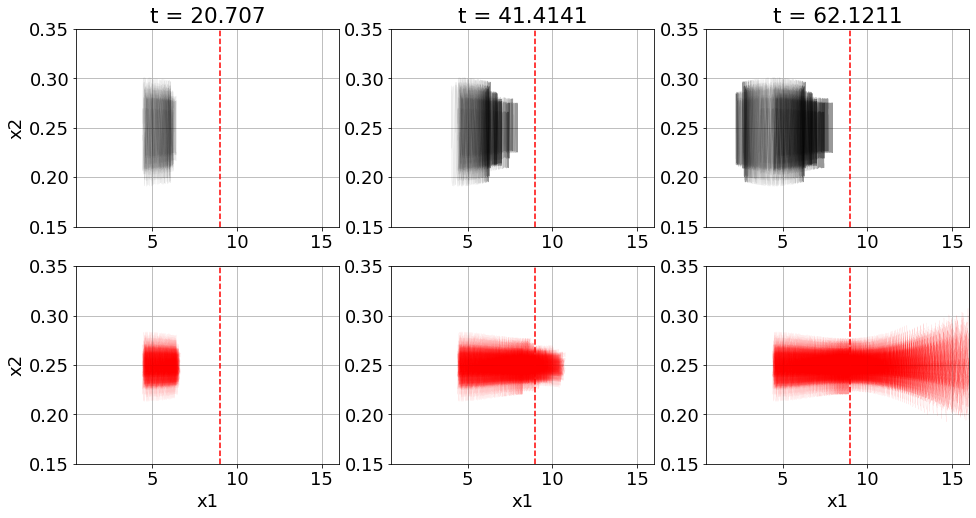

In [764]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))

tstep=-1
for j in bound_idx[::32]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[j][:tstep]]
    e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in a[j][:tstep]]
    axes[0,0].plot(e_posx_t[:300],e_posy_t[:300],c="k",alpha=0.4,lw=0.1)
    axes[0,1].plot(e_posx_t[:900],e_posy_t[:900],c="k",alpha=0.4,lw=0.1)
    axes[0,2].plot(e_posx_t,e_posy_t,c="k",alpha=0.4,lw=0.1)

axes[0,0].set_title("t = {:g}".format(dt*1500))
axes[0,1].set_title("t = {:g}".format(dt*3000))
axes[0,2].set_title("t = {:g}".format(dt*4500))

for j in unbound_idx[::16]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[j][:tstep]]
    e_posy_t=[(i['iy']+i['y'])*box[1]/nx[1] for i in a[j][:tstep]]
    axes[1,0].plot(e_posx_t[:300],e_posy_t[:300],c="r",alpha=0.4,lw=0.1)
    axes[1,1].plot(e_posx_t[:900],e_posy_t[:900],c="r",alpha=0.4,lw=0.1)
    axes[1,2].plot(e_posx_t,e_posy_t,c="r",alpha=0.4,lw=0.1)

for ax in axes[1]:
    ax.set_xlabel("x1")

for ax in axes[:,0]:
    ax.set_ylabel("x2")

for ax in axes:
    for ax_ in ax:
        ax_.set_ylim(0.15,0.35)
        ax_.set_xlim(0.5,16)
        ax_.axvline(9,ls="--",c="r")
        ax_.grid()

plt.show()

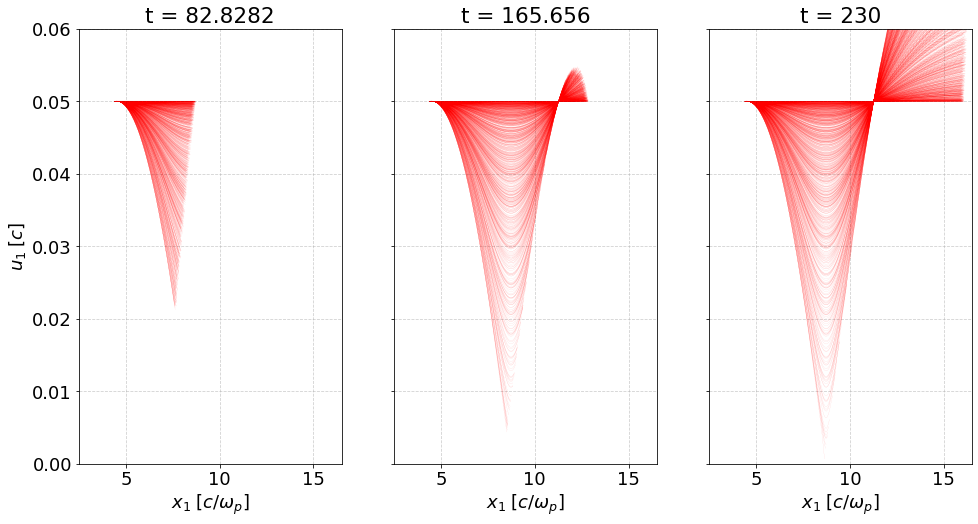

In [765]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))

for ax in axes:
        ax.set_ylim(0.0,0.06)
        ax.set_xlim(2.5,16.5)
        ax.set_xlabel("$x_1\;[c/\omega_p]$")
        ax.grid(alpha=0.6,ls="--")

axes[0].set_title("t = {:g}".format(dt*6000))
axes[0].set_ylabel("$u_1\;[c]$")
axes[1].set_yticklabels([])
axes[1].set_title("t = {:g}".format(dt*12000))

axes[2].set_yticklabels([])
axes[2].set_title("t = {:g}".format(dt*sim.n))


for j in unbound_idx[::]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[j][:tstep]]
    e_posy_t=[i['ux'] for i in a[j][:tstep]]
    axes[0].plot(e_posx_t[:600],e_posy_t[:600],c="r",alpha=0.4,lw=0.1)
    axes[1].plot(e_posx_t[:1200],e_posy_t[:1200],c="r",alpha=0.4,lw=0.1)
    axes[2].plot(e_posx_t,e_posy_t,c="r",alpha=0.4,lw=0.1)


plt.show()

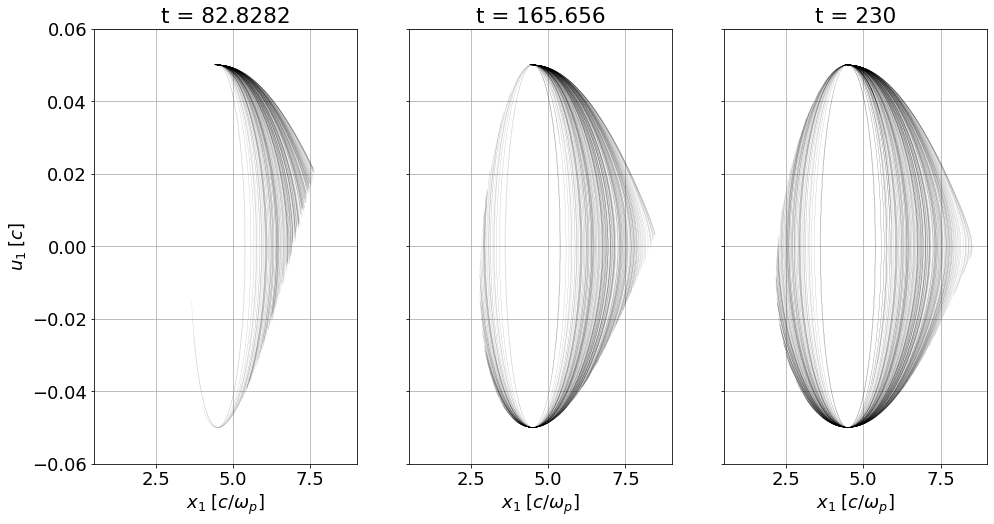

In [766]:
import matplotlib.pyplot as plt
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(16, 8))


for j in bound_idx[::]:
    e_posx_t=[(i['ix']+i['x'])*box[0]/nx[0] for i in a[j][:tstep]]
    e_posy_t=[i['ux'] for i in a[j][:tstep]]
    axes[0].plot(e_posx_t[:600],e_posy_t[:600],c="k",alpha=0.4,lw=0.1)
    axes[1].plot(e_posx_t[:1200],e_posy_t[:1200],c="k",alpha=0.4,lw=0.1)
    axes[2].plot(e_posx_t,e_posy_t,c="k",alpha=0.4,lw=0.1)

axes[0].set_title("t = {:g}".format(dt*6000))
axes[0].set_ylabel("$u_1\;[c]$")
axes[1].set_yticklabels([])
axes[1].set_title("t = {:g}".format(dt*12000))

axes[2].set_yticklabels([])
axes[2].set_title("t = {:g}".format(dt*sim.n))

for ax in axes:
        ax.set_ylim(-0.06,0.06)
        ax.set_xlim(0.5,9)
        ax.set_xlabel("$x_1\;[c/\omega_p]$")
        ax.grid()

plt.show()

This clear distinction can also be observed in the $u_y$ histogram. All particles have the same long. velocity so only particles with high enough $u_y$ are trapped.

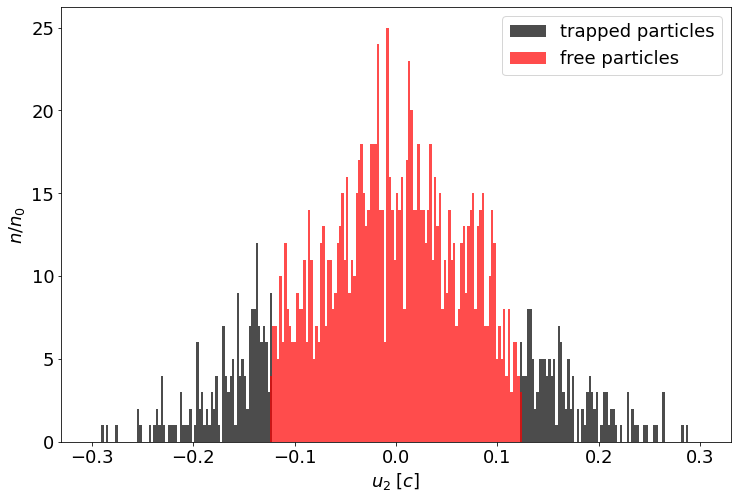

In [808]:
umax = 0.3
nbins = 256

plt.figure(figsize=(12,8))

bound_ux=[a[i][0]['uy'] for i in bound_idx]

plt.hist( bound_ux, bins = nbins, range = (-umax, umax),  label ='trapped particles' ,alpha=0.7,color="k")

unbound_ux=[a[i][0]['uy'] for i in unbound_idx]

plt.hist( unbound_ux, bins = nbins, range = (-umax, umax),  label ='free particles' ,alpha=0.7,color="r")


plt.xlabel("$ u_2\;[c] $")
plt.ylabel("$ n / n_0 $")

plt.legend()
plt.show()

***
***